# Initial

In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

import torch, random, numpy as np
from transformers import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(9)

from safetensors import safe_open

import matplotlib.pyplot as plt
import seaborn as sns

# Assign Prompts
All codes are for PyTorch side.

Run the following equivalent commands (select one) for the Kornia-rs side. (Activations are compared via the implicitly saved safetensor files.)
```sh
cargo run -p smol_vlm --features cuda -- -i .vscode/angela-porter-2021-jan-25.jpg -p "Can you describe the image?" --sample-length 500
cargo run -p smol_vlm --features cuda -- -p "A real-valued function f defined on the real line is called an even function if f(-t) = f(t) for each real number t. Prove that the set of even functions defined on the real line with the operations of addition and scalar multiplication defined in Example 3 is a vector space." --sample-length 200
cargo run -p smol_vlm --features cuda -- -p "Can you describe the image?" --sample-length 500 --image-path "/home/ahc/Documents/kornia-rs/examples/smol_vlm/validation_data/angela-porter-2021-jan-25.jpg"
cargo run -p smol_vlm --features cuda -- -p "What is life?" --sample-length 500
```

In [2]:
# image1 = load_image("https://media.istockphoto.com/id/485371557/photo/twilight-at-spirit-island.jpg?s=612x612&w=0&k=20&c=FSGliJ4EKFP70Yjpzso0HfRR4WwflC6GKfl4F3Hj7fk=")
# image2 = load_image("https://huggingface.co/spaces/merve/chameleon-7b/resolve/main/bee.jpg")
# image1 = Image.open("../../../.vscode/fuji-mountain-in-autumn.jpg")
# image1 = load_image("https://artwyrd.com/wp-content/uploads/2021/01/angela-porter-2021-jan-25.jpg")
image1 = load_image("../validation_data/IMG_8750.jpg")
# image1 = load_image("../validation_data/1920x1080-white-solid-color-background.jpg")
print(f"Image 1 size: {image1.size}")


processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
messages = [
    {
        "role": "user",
        "content": [
            # {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe the image?"}
            # {"type": "text", "text": "What is life?"}
            # {"type": "text", "text": "A real-valued function f defined on the real line is called an even function if f(-t) = f(t) for each real number t. Prove that the set of even functions defined on the real line with the operations of addition and scalar multiplication defined in Example 3 is a vector space."}
        ]
    },
]

Image 1 size: (4032, 3024)


In [3]:
processor

Idefics3Processor:
- image_processor: Idefics3ImageProcessor {
  "do_convert_rgb": true,
  "do_image_splitting": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "Idefics3ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "max_image_size": {
    "longest_edge": 384
  },
  "processor_class": "Idefics3Processor",
  "resample": 1,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1536
  }
}

- tokenizer: GPT2TokenizerFast(name_or_path='HuggingFaceTB/SmolVLM-Instruct', vocab_size=49152, model_max_length=16384, is_fast=True, padding_side='right', truncation_side='left', special_tokens={'bos_token': '<|im_start|>', 'eos_token': '<end_of_utterance>', 'unk_token': '<|endoftext|>', 'pad_token': '<|im_end|>', 'additional_special_tokens': ['<fake_token_around_image>', '<image>', '<end_of_utterance>']}, clean_up_tokenization_spaces=False, added

# Activation introspection

In [4]:
from collections import OrderedDict
from activation_introspector import ActivationIntrospector

DEVICE = "cpu"  # "cuda"

# Initialize model directly on CUDA without Flash Attention
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    # _attn_implementation="flash_attention_2",  # Commented out Flash Attention
    # torch_dtype=torch.bfloat16,
    _attn_implementation="eager",
    torch_dtype=torch.float32,
    device_map=DEVICE,
)
model.eval()



act_isp = ActivationIntrospector()
layers = OrderedDict()

layers["input_embeddings"] = model.get_input_embeddings()
for i in range(24):
    layers[f"input_layernorm_d{i}"] = model.model.text_model.layers[i].input_layernorm
    layers[f"self_attn_d{i}"]       = model.model.text_model.layers[i].self_attn
    layers[f"post_layernorm_d{i}"]  = model.model.text_model.layers[i].post_attention_layernorm
    #  layer[f"mlp_d{i}"]             = model.model.text_model.layers[i].mlp
    layers[f"mlp_gate_proj_d{i}"]   = model.model.text_model.layers[i].mlp.gate_proj
    layers[f"mlp_up_proj_d{i}"]     = model.model.text_model.layers[i].mlp.up_proj
    layers[f"mlp_down_proj_d{i}"]   = model.model.text_model.layers[i].mlp.down_proj
    layers[f"mlp_act_fn_d{i}"]      = model.model.text_model.layers[i].mlp.act_fn
    layers[f"layers_d{i}"]          = model.model.text_model.layers[i]
layers["logits"] = model.get_output_embeddings()

act_isp.set_introspector(layers)



act_isp_vision = ActivationIntrospector()
layers_vision = OrderedDict()

layers_vision["patch_embeddings"] = model.model.vision_model.embeddings.patch_embedding
layers_vision["position_embeddings"] = model.model.vision_model.embeddings.position_embedding
for i in range(27):
    layers_vision[f"input_layernorm_d{i}"] = model.model.vision_model.encoder.layers[i].layer_norm1
    layers_vision[f"self_attn_d{i}"]       = model.model.vision_model.encoder.layers[i].self_attn
    layers_vision[f"post_layernorm_d{i}"]  = model.model.vision_model.encoder.layers[i].layer_norm2
    layers_vision[f"mlp_act_fn_d{i}"]   = model.model.vision_model.encoder.layers[i].mlp.activation_fn
    layers_vision[f"fc1_d{i}"]     = model.model.vision_model.encoder.layers[i].mlp.fc1
    layers_vision[f"fc2_d{i}"]   = model.model.vision_model.encoder.layers[i].mlp.fc2
layers_vision[f"post_layernorm"]          = model.model.vision_model.post_layernorm

act_isp_vision.set_introspector(layers_vision)

type(model)

transformers.models.idefics3.modeling_idefics3.Idefics3ForConditionalGeneration

In [5]:
model;

# Generation

In [6]:
act_isp.clear()
act_isp_vision.clear()

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1], return_tensors="pt")
# inputs = processor(text=prompt, return_tensors="pt")
inputs = inputs.to(DEVICE)

print(inputs["input_ids"])
# Generate outputs
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=500,
        # repition_penalty=1.1,  # Apply repeat penalty
        output_scores=True,           # Return logits for each generated token
        return_dict_in_generate=True, # Return detailed output object
        do_sample=False,  # Use greedy decoding (highest logit)
    )

outputs.sequences[0]

tensor([[    1, 11126,    42,  ...,  9519,  9531,    42]])


tensor([    1, 11126,    42,  ...,   351,   476,  2089])

In [7]:
processor.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

'User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>\n<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>\n<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>\n\n<global-img>Can you describe the image?\nAssistant: The image depicts a whiteboard with handwritten mathematical equations and notes. The whiteboard is mounted on a wall, and the writing is done in black marker. The equations and notes are written in a clear and legible manner.\n\n### Detailed Description:\n\n#### **Top Section (Left to Right):**\n\n1. **First Equation:**\n   - The first equation is written in the middle of the whiteboard.\n   - It starts with "Here, either f(x) or f(x1) is discontinuous at x."\n   - The equation is incomplete, and the rest of the text is not visible.\n\n2. **Second Equation:**\n   - The second equation is also written in the middle of the whiteboard.\n   - It starts with "On the other hand, f(x) = 1 - 1 = 0"\n   - The equation is incomplete, and the rest of the text is not visible.\n\

# Validation

In [8]:
(model.model.vision_model.encoder.layers[0].layer_norm1.weight,
 model.model.vision_model.encoder.layers[0].layer_norm1.bias)

(Parameter containing:
 tensor([ 3.8086e-01, -4.6997e-03,  8.5938e-02,  ...,  1.6250e+00,
          1.2402e-01,  1.2360e-03], requires_grad=True),
 Parameter containing:
 tensor([-0.0051,  0.0008,  0.0113,  ..., -0.0215,  0.0250, -0.0011],
        requires_grad=True))

In [9]:
with safe_open("/home/ahc/.cache/huggingface/hub/models--HuggingFaceTB--SmolVLM-Instruct/snapshots/81cd9a775a4d644f2faf4e7becff4559b46b14c7/model.safetensors", framework="pt", device="cpu") as f:
    print(f.get_tensor("model.vision_model.encoder.layers.26.layer_norm1.bias"))
    print(
        torch.functional.F.mse_loss(model.model.vision_model.encoder.layers[26].layer_norm1.bias.cuda(),
        f.get_tensor("model.vision_model.encoder.layers.26.layer_norm1.bias").cuda())
    )

tensor([-0.1465,  0.0693, -0.0679,  ...,  0.1631, -0.1406, -0.0183],
       dtype=torch.bfloat16)
tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)


In [10]:
calc_err = lambda rust, python: (
    torch.nn.functional.mse_loss(rust.squeeze(), python.squeeze()).item(),
    torch.nn.functional.l1_loss(rust.squeeze(), python.squeeze()).item()
)
PATCH_BLOCKS = (3,4)
calc_spatial_err = lambda rust, python: ((rust-python)**2).mean(dim=-1)[:-1].reshape(*PATCH_BLOCKS, 27, 27).permute(0,2,1,3).reshape(PATCH_BLOCKS[0]*27,PATCH_BLOCKS[1]*27).float()
calc_patch_embed_err = lambda rust, python: ((rust-python)**2).mean(dim=1)[:-1].reshape(*PATCH_BLOCKS, 27, 27).permute(0,2,1,3).reshape(PATCH_BLOCKS[0]*27,PATCH_BLOCKS[1]*27).float()
top_err = lambda rust, python: (rust.argsort(descending=True)[0].item(), python.squeeze().argsort(descending=True)[0].item())
topK_logits = lambda rust, python: (rust.argsort(descending=True)[:15], python.squeeze().argsort(descending=True)[:15])

err_fmt = lambda mse, mae: f"(MSE:{mse:.8f}, MAE:{mae:.8f})"

In [11]:
TOKEN_MAX_IND = 94
TOKEN_RANGE = range(TOKEN_MAX_IND)

with safe_open("../validation_data/rust_isp_decoder.safetensors", framework="pt", device="cpu") as f:
    logits_output = act_isp.compare_rust_activations(
        TOKEN_RANGE, f, top_err, subset=["logits"]
    )
    for i in TOKEN_RANGE:
        top_logits_rust = logits_output[f"logits_i{i}"][0]
        top_logits_python = logits_output[f"logits_i{i}"][1]
        if top_logits_python != top_logits_rust:
            print(f"Mismatch at index {i}: Python top {top_logits_python}, Rust top {top_logits_rust}")
            ind_div = i
            break

    topK_logits_output = act_isp.compare_rust_activations(TOKEN_RANGE, f, topK_logits, subset=["logits"])
    all_output = act_isp.compare_rust_activations(TOKEN_RANGE, f, calc_err)
    for i in range(max(0,ind_div-3), ind_div+2):
        print(f"[{i:>3}] EMBEDS{err_fmt(*all_output[f"input_embeddings_i{i}"])}  LOGITS{err_fmt(*all_output[f"logits_i{i}"])} ")

        top_logits_rust = topK_logits_output[f"logits_i{i}"][0]
        top_logits_python = topK_logits_output[f"logits_i{i}"][1]
        rust_logits = f.get_tensor(f"logits_i{i}").squeeze().cpu()
        python_logits = act_isp.activations[f"logits_i{i}"].squeeze().cpu()

        print(f"[PYTHON] Logits: {[python_logits[i].item() for i in top_logits_python]}, Tokens: {[processor.tokenizer.decode([i]) for i in top_logits_python]}")
        print(f"         Tokens:", [i.item() for i in top_logits_python])
        print(f"[RUST] Logits: {[rust_logits[i].item() for i in top_logits_rust]}, Tokens: {[processor.tokenizer.decode([i]) for i in top_logits_rust]}")
        print(f"         Tokens:", [i.item() for i in top_logits_rust])


        # for layer_d in [0]:
        for layer_d in range(24):
            layer_fmt = lambda layer: err_fmt(*all_output[f"{layer}_d{layer_d}_i{i}"])

            print(f"    [INPUT LAYERNORM]   {layer_fmt("input_layernorm")}")
            print(f"    [SELF ATTN]         {layer_fmt("self_attn")}")
            print(f"    [POST LAYERNORM]    {layer_fmt("post_layernorm")}")
            # print(f"    [MLP]              {layer_fmt("mlp")}")
            print(f"        [MLP/GATE PROJ] {layer_fmt("mlp_gate_proj")}")
            print(f"        [MLP/ACT FN]    {layer_fmt("mlp_act_fn")}")
            print(f"        [MLP/UP PROJ]   {layer_fmt("mlp_up_proj")}")
            print(f"        [MLP/DOWN PROJ] {layer_fmt("mlp_down_proj")}")
            print(f"[LAYER {layer_d:>2}]        {layer_fmt("layers")}")

Mismatch at index 2: Python top 21559, Rust top 314
[  0] EMBEDS(MSE:0.00000000, MAE:0.00000000)  LOGITS(MSE:1.65662956, MAE:1.02314889) 
[PYTHON] Logits: [18.862560272216797, 14.851916313171387, 14.745491981506348, 14.522679328918457, 14.105412483215332, 14.054923057556152, 13.495819091796875, 13.276588439941406, 13.06424331665039, 13.013014793395996, 12.979280471801758, 12.855765342712402, 12.786613464355469, 12.75865650177002, 12.679887771606445], Tokens: [' The', ' In', ' This', ' There', ' A', ' Yes', ' ###', ' On', ' As', ' To', ' Unfortunately', ' I', ' At', ' It', ' Sure']
         Tokens: [378, 533, 669, 1385, 330, 9230, 20749, 1985, 1032, 1626, 8286, 339, 1814, 657, 16096]
[RUST] Logits: [17.80133819580078, 15.756897926330566, 15.35234260559082, 15.185300827026367, 15.029752731323242, 14.968751907348633, 14.230913162231445, 13.901952743530273, 13.755577087402344, 13.454764366149902, 13.298358917236328, 12.996234893798828, 12.451396942138672, 12.442052841186523, 12.36827468872

In [12]:
with safe_open("../validation_data/rust_isp_encoder.safetensors", framework="pt", device="cpu") as f:
    err_result = act_isp_vision.compare_rust_activations(range(1), f, calc_err)
    err_result_spatial = act_isp_vision.compare_rust_activations(
        range(1), f, calc_spatial_err,
        subset=[f"input_layernorm_d{layer_d}" for layer_d in range(27)] + [f"post_layernorm_d{layer_d}" for layer_d in range(27)]
    )
    err_result_patch_embed = act_isp_vision.compare_rust_activations(
        range(1), f, calc_patch_embed_err,
        subset=["patch_embeddings"]
    )

    for i in range(1):
        print(f"============== IMAGE [{i:>3}] ==============")
        print(f"PATCH_EMBEDS{err_fmt(*err_result[f"patch_embeddings_i{i}"])}")
        print(f"POS_EMBEDS{err_fmt(*err_result[f"position_embeddings_i{i}"])}")

        for layer_d in range(27):
            layer_fmt = lambda layer: err_fmt(*err_result[f"{layer}_d{layer_d}_i{i}"])

            print(f"[LAYER {layer_d:>2}]")
            print(f"    [INPUT LAYERNORM]   {layer_fmt("input_layernorm")}")
            print(f"    [SELF ATTN]         {layer_fmt("self_attn")}")
            print(f"    [POST LAYERNORM]    {layer_fmt("post_layernorm")}")
            print(f"        [MLP/FC1]       {layer_fmt("fc1")}")
            print(f"        [MLP/ACT FN]    {layer_fmt("mlp_act_fn")}")
            print(f"        [MLP/FC2]       {layer_fmt("fc2")}")

        print(f"[POST POST LAYERNORM]   {layer_fmt("post_layernorm")}")

============== IMAGE [  0] ==============
PATCH_EMBEDS(MSE:0.03248513, MAE:0.03216225)
POS_EMBEDS(MSE:0.01077055, MAE:0.00323809)
[LAYER  0]
    [INPUT LAYERNORM]   (MSE:0.00441082, MAE:0.00656496)
    [SELF ATTN]         (MSE:0.00074865, MAE:0.00362511)
    [POST LAYERNORM]    (MSE:0.02116053, MAE:0.02104753)
        [MLP/FC1]       (MSE:0.02972047, MAE:0.03737995)
        [MLP/ACT FN]    (MSE:0.00188686, MAE:0.00374400)
        [MLP/FC2]       (MSE:0.00411343, MAE:0.01205190)
[LAYER  1]
    [INPUT LAYERNORM]   (MSE:0.01243638, MAE:0.01262049)
    [SELF ATTN]         (MSE:0.00046066, MAE:0.00327552)
    [POST LAYERNORM]    (MSE:0.02759348, MAE:0.02292408)
        [MLP/FC1]       (MSE:0.03764533, MAE:0.03636349)
        [MLP/ACT FN]    (MSE:0.00059160, MAE:0.00335164)
        [MLP/FC2]       (MSE:0.00202931, MAE:0.01015992)
[LAYER  2]
    [INPUT LAYERNORM]   (MSE:0.02402419, MAE:0.02169801)
    [SELF ATTN]         (MSE:0.00127623, MAE:0.00754875)
    [POST LAYERNORM]    (MSE:0.04180888

In [18]:
"""
From my personal image:
============== IMAGE [  0] ==============
PATCH_EMBEDS(MSE:0.03247070, MAE:0.03222656)
POS_EMBEDS(MSE:0.01074219, MAE:0.00323486)


For the green background circle image:
============== IMAGE [  0] ==============
PATCH_EMBEDS(MSE:0.00001019, MAE:0.00192261)
POS_EMBEDS(MSE:0.00000000, MAE:0.00000000)


Purely blank white image:
============== IMAGE [  0] ==============
PATCH_EMBEDS(MSE:1.25781250, MAE:0.57421875)
POS_EMBEDS(MSE:0.11132812, MAE:0.04541016)
""";

# Visualization

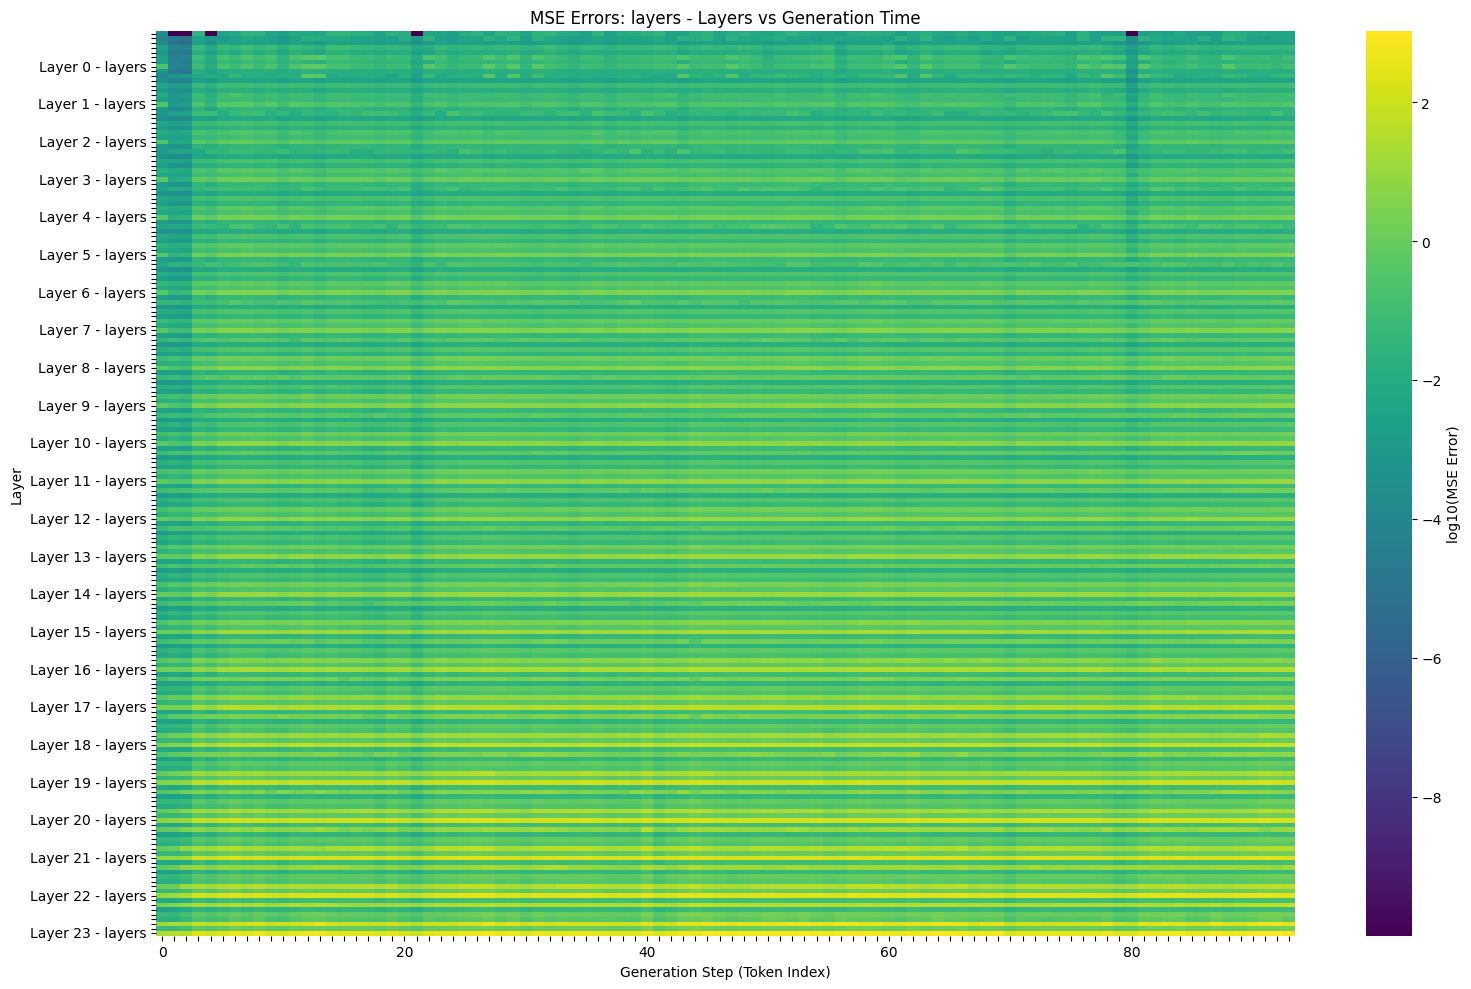

In [13]:
def visualize_layer_time_heatmap(error_type='layers', max_tokens=200, component='layers'):
    """
    Create a heatmap with layers on y-axis and time/tokens on x-axis
    
    Args:
        error_type: 'mse' or 'mae'
        max_tokens: Maximum number of tokens/time steps to show
        component: Which component to visualize ('layers', 'input_layernorm', 'self_attn', etc.)
    """
    layers = 24
    time_steps = min(max_tokens, 200)  # Adjust based on your data
    components = ['input_layernorm', 'self_attn', 'post_layernorm', 'mlp_gate_proj', 'mlp_act_fn', 'mlp_down_proj', 'mlp_up_proj', 'layers']
    
    # Initialize error matrix: [layers, time_steps]
    error_matrix = np.zeros((layers*len(components), time_steps))
    
    for t in range(time_steps):
        for layer in range(layers):
            for i,c in enumerate(components):
                error_matrix[layer*len(components)+i, t] = all_output[f"{c}_d{layer}_i{t}"][0]
    
    # Create the heatmap
    plt.figure(figsize=(16, 10))
    
    # Use log scale for better visualization of small errors
    log_errors = np.log10(error_matrix + 1e-10)  # Add small value to avoid log(0)
    
    sns.heatmap(log_errors,
                cmap='viridis',
                cbar_kws={'label': f'log10({error_type.upper()} Error)'},
                xticklabels=[f'{i}' if i % 20 == 0 else '' for i in range(time_steps)],
                yticklabels=[f'Layer {i//len(components)} - {components[i%len(components)]}' if i%len(components) == (len(components)-1) else "" for i in range(layers*len(components))])
    
    plt.title(f'{error_type.upper()} Errors: {component} - Layers vs Generation Time')
    plt.xlabel('Generation Step (Token Index)')
    plt.ylabel('Layer')
    plt.tight_layout()
    plt.show()
    
    return error_matrix

def visualize_multiple_components_over_time(max_tokens=150):
    """
    Create multiple heatmaps for different components showing layer vs time
    with standardized color scale across all subplots
    """
    components = ['input_layernorm', 'self_attn', 'post_layernorm', 'mlp_gate_proj', 'mlp_act_fn', 'mlp_down_proj', 'mlp_up_proj', 'layers']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # Collect all error matrices first to determine global min/max
    all_error_matrices = []
    
    for component in components:
        layers = 24
        time_steps = max_tokens
        error_matrix = np.zeros((layers, time_steps))
        
        for layer in range(layers):
            for t in range(time_steps):
                error_matrix[layer, t] = all_output[f"{component}_d{layer}_i{t}"][0]
        
        all_error_matrices.append(error_matrix)
    
    # Calculate global min and max for standardized scale
    all_log_errors = [np.log10(matrix + 1e-10) for matrix in all_error_matrices]
    global_vmin = min(matrix.min() for matrix in all_log_errors)
    global_vmax = max(matrix.max() for matrix in all_log_errors)
    
    print(f"Global log10 error range: [{global_vmin:.2f}, {global_vmax:.2f}]")
    
    # Create heatmaps with standardized scale
    for idx, (component, error_matrix) in enumerate(zip(components, all_error_matrices)):
        if idx >= len(axes):
            break
        
        log_errors = np.log10(error_matrix + 1e-10)
        
        sns.heatmap(log_errors,
                    cmap='plasma',
                    ax=axes[idx],
                    vmin=global_vmin,  # Standardized min
                    vmax=global_vmax,  # Standardized max
                    cbar_kws={'label': 'log10(MSE)'} if idx == 0 else {'label': ''},
                    xticklabels=[f'{i}' if i % 20 == 0 else '' for i in range(max_tokens)],
                    yticklabels=[f'{i}' if i % 4 == 0 else '' for i in range(24)])
        
        axes[idx].set_title(f'{component}')
        axes[idx].set_xlabel('Generation Step')
        axes[idx].set_ylabel('Layer')
    
    # Hide any unused subplots
    for idx in range(len(components), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('MSE Errors Across Components: Layers vs Time', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
error_matrix = visualize_layer_time_heatmap('mse', max_tokens=TOKEN_MAX_IND, component='layers')
# visualize_multiple_components_over_time()

=== Vision Encoder MSE Errors ===
Vision Encoder Error Statistics (MSE):
Min error: 4.61e-04
Max error: 6.86e+01
Mean error: 7.95e-01
Highest error at: fc2 in layer 26 = 6.86e+01


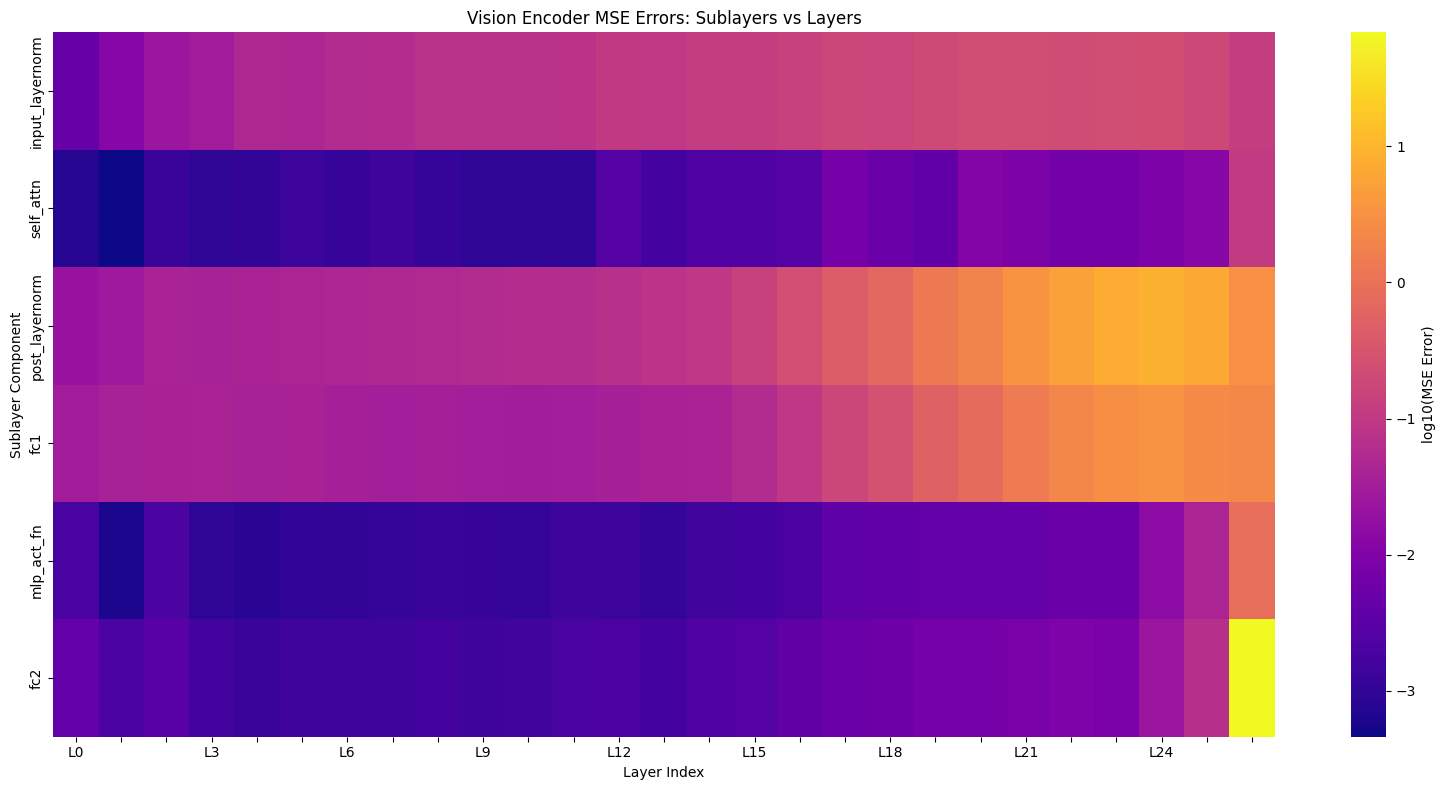


=== Vision Encoder MAE Errors ===
Vision Encoder Error Statistics (MAE):
Min error: 1.66e-03
Max error: 8.86e-01
Mean error: 9.04e-02
Highest error at: post_layernorm in layer 24 = 8.86e-01


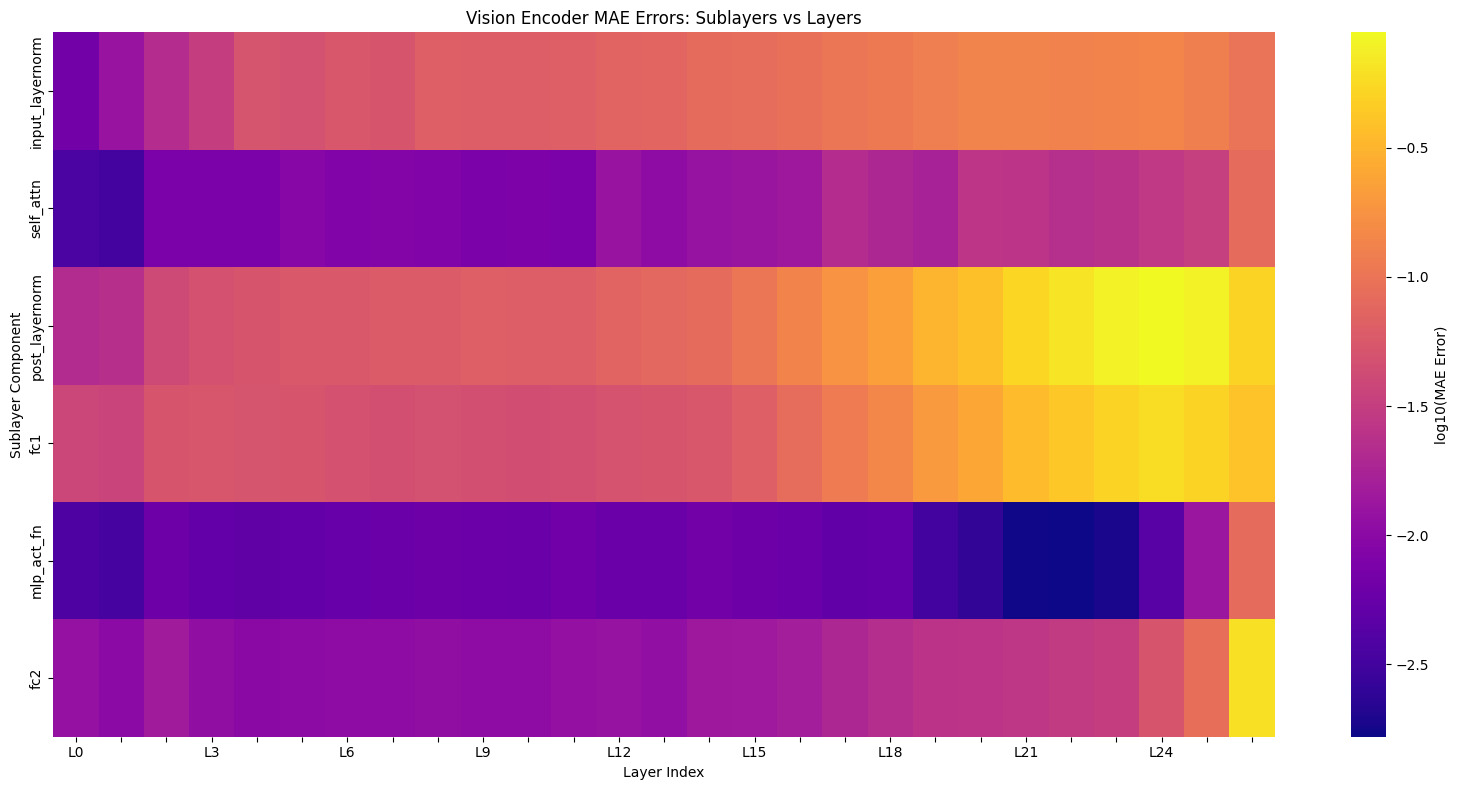


=== Side-by-side Comparison ===


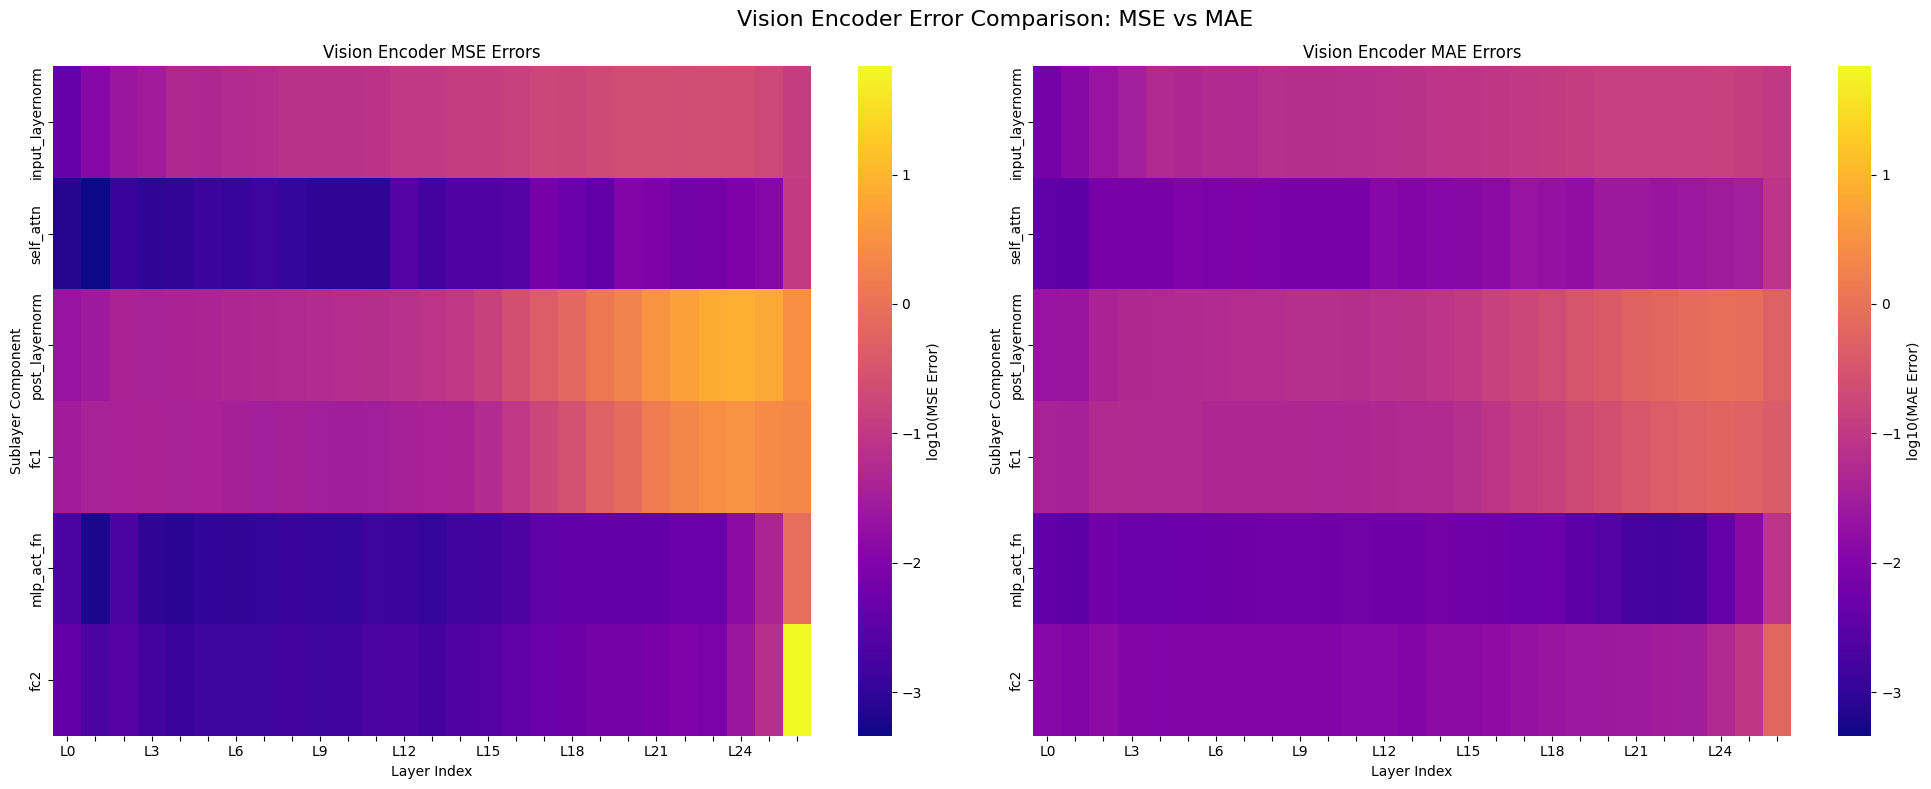

In [14]:
def visualize_vision_encoder_sublayers(error_result, error_type='mse'):
    """
    Create a heatmap for vision encoder errors with layers on x-axis and sublayers on y-axis
    
    Args:
        error_result: Dictionary containing vision encoder error results
        error_type: 'mse' or 'mae' (0 for MSE, 1 for MAE in the tuple)
    """
    num_layers = 27
    
    # Define sublayers for vision encoder
    sublayers = [
        'input_layernorm',
        'self_attn', 
        'post_layernorm',
        'fc1',
        'mlp_act_fn',
        'fc2'
    ]
    
    # Create error matrix: [sublayers, layers]
    error_matrix = np.zeros((len(sublayers), num_layers))
    error_idx = 0 if error_type == 'mse' else 1
    
    # Fill the matrix with error values
    for layer_idx in range(num_layers):
        for sublayer_idx, sublayer in enumerate(sublayers):
            key = f"{sublayer}_d{layer_idx}_i0"  # i0 since vision encoder processes one image
            if key in error_result:
                error_matrix[sublayer_idx, layer_idx] = error_result[key][error_idx]
    
    # Create the visualization
    plt.figure(figsize=(16, 8))
    
    # Use log scale for better visualization
    log_errors = np.log10(error_matrix + 1e-12)  # Add small value to avoid log(0)
    
    # Create heatmap
    sns.heatmap(log_errors,
                cmap='plasma',
                cbar_kws={'label': f'log10({error_type.upper()} Error)'},
                xticklabels=[f'L{i}' if i % 3 == 0 else '' for i in range(num_layers)],
                yticklabels=sublayers,
                annot=False)
    
    plt.title(f'Vision Encoder {error_type.upper()} Errors: Sublayers vs Layers')
    plt.xlabel('Layer Index')
    plt.ylabel('Sublayer Component')
    plt.tight_layout()
    
    # Print some statistics
    print(f"Vision Encoder Error Statistics ({error_type.upper()}):")
    print(f"Min error: {error_matrix.min():.2e}")
    print(f"Max error: {error_matrix.max():.2e}")
    print(f"Mean error: {error_matrix.mean():.2e}")
    
    # Find layers/sublayers with highest errors
    max_pos = np.unravel_index(np.argmax(error_matrix), error_matrix.shape)
    print(f"Highest error at: {sublayers[max_pos[0]]} in layer {max_pos[1]} = {error_matrix[max_pos]:.2e}")
    
    plt.show()
    
    return error_matrix

def visualize_vision_encoder_comparison():
    """
    Create side-by-side comparison of MSE and MAE errors for vision encoder
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    num_layers = 27
    sublayers = [
        'input_layernorm',
        'self_attn', 
        'post_layernorm',
        'fc1',
        'mlp_act_fn',
        'fc2'
    ]
    
    # Create error matrices for both MSE and MAE
    mse_matrix = np.zeros((len(sublayers), num_layers))
    mae_matrix = np.zeros((len(sublayers), num_layers))
    
    for layer_idx in range(num_layers):
        for sublayer_idx, sublayer in enumerate(sublayers):
            key = f"{sublayer}_d{layer_idx}_i0"
            if key in err_result:
                mse_matrix[sublayer_idx, layer_idx] = err_result[key][0]  # MSE
                mae_matrix[sublayer_idx, layer_idx] = err_result[key][1]  # MAE
    
    # Calculate global min/max for consistent color scaling
    mse_log = np.log10(mse_matrix + 1e-12)
    mae_log = np.log10(mae_matrix + 1e-12)
    
    global_vmin = min(mse_log.min(), mae_log.min())
    global_vmax = max(mse_log.max(), mae_log.max())
    
    # MSE heatmap
    sns.heatmap(mse_log,
                cmap='plasma',
                ax=ax1,
                vmin=global_vmin,
                vmax=global_vmax,
                cbar_kws={'label': 'log10(MSE Error)'},
                xticklabels=[f'L{i}' if i % 3 == 0 else '' for i in range(num_layers)],
                yticklabels=sublayers)
    
    ax1.set_title('Vision Encoder MSE Errors')
    ax1.set_xlabel('Layer Index')
    ax1.set_ylabel('Sublayer Component')
    
    # MAE heatmap
    sns.heatmap(mae_log,
                cmap='plasma',
                ax=ax2,
                vmin=global_vmin,
                vmax=global_vmax,
                cbar_kws={'label': 'log10(MAE Error)'},
                xticklabels=[f'L{i}' if i % 3 == 0 else '' for i in range(num_layers)],
                yticklabels=sublayers)
    
    ax2.set_title('Vision Encoder MAE Errors')
    ax2.set_xlabel('Layer Index')
    ax2.set_ylabel('Sublayer Component')
    
    plt.suptitle('Vision Encoder Error Comparison: MSE vs MAE', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return mse_matrix, mae_matrix

# Generate the visualizations
print("=== Vision Encoder MSE Errors ===")
mse_matrix = visualize_vision_encoder_sublayers(err_result, 'mse')

print("\n=== Vision Encoder MAE Errors ===")
mae_matrix = visualize_vision_encoder_sublayers(err_result, 'mae')

print("\n=== Side-by-side Comparison ===")
mse_comp, mae_comp = visualize_vision_encoder_comparison()

In [176]:
err_result_spatial.keys()

odict_keys(['input_layernorm_d0_i0', 'post_layernorm_d0_i0', 'input_layernorm_d1_i0', 'post_layernorm_d1_i0', 'input_layernorm_d2_i0', 'post_layernorm_d2_i0', 'input_layernorm_d3_i0', 'post_layernorm_d3_i0', 'input_layernorm_d4_i0', 'post_layernorm_d4_i0', 'input_layernorm_d5_i0', 'post_layernorm_d5_i0', 'input_layernorm_d6_i0', 'post_layernorm_d6_i0', 'input_layernorm_d7_i0', 'post_layernorm_d7_i0', 'input_layernorm_d8_i0', 'post_layernorm_d8_i0', 'input_layernorm_d9_i0', 'post_layernorm_d9_i0', 'input_layernorm_d10_i0', 'post_layernorm_d10_i0', 'input_layernorm_d11_i0', 'post_layernorm_d11_i0', 'input_layernorm_d12_i0', 'post_layernorm_d12_i0', 'input_layernorm_d13_i0', 'post_layernorm_d13_i0', 'input_layernorm_d14_i0', 'post_layernorm_d14_i0', 'input_layernorm_d15_i0', 'post_layernorm_d15_i0', 'input_layernorm_d16_i0', 'post_layernorm_d16_i0', 'input_layernorm_d17_i0', 'post_layernorm_d17_i0', 'input_layernorm_d18_i0', 'post_layernorm_d18_i0', 'input_layernorm_d19_i0', 'post_layerno

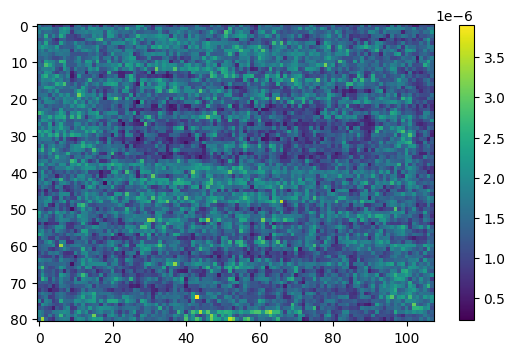

In [15]:
im = plt.imshow(err_result_patch_embed["patch_embeddings_i0"])
plt.colorbar(im, shrink=0.8)

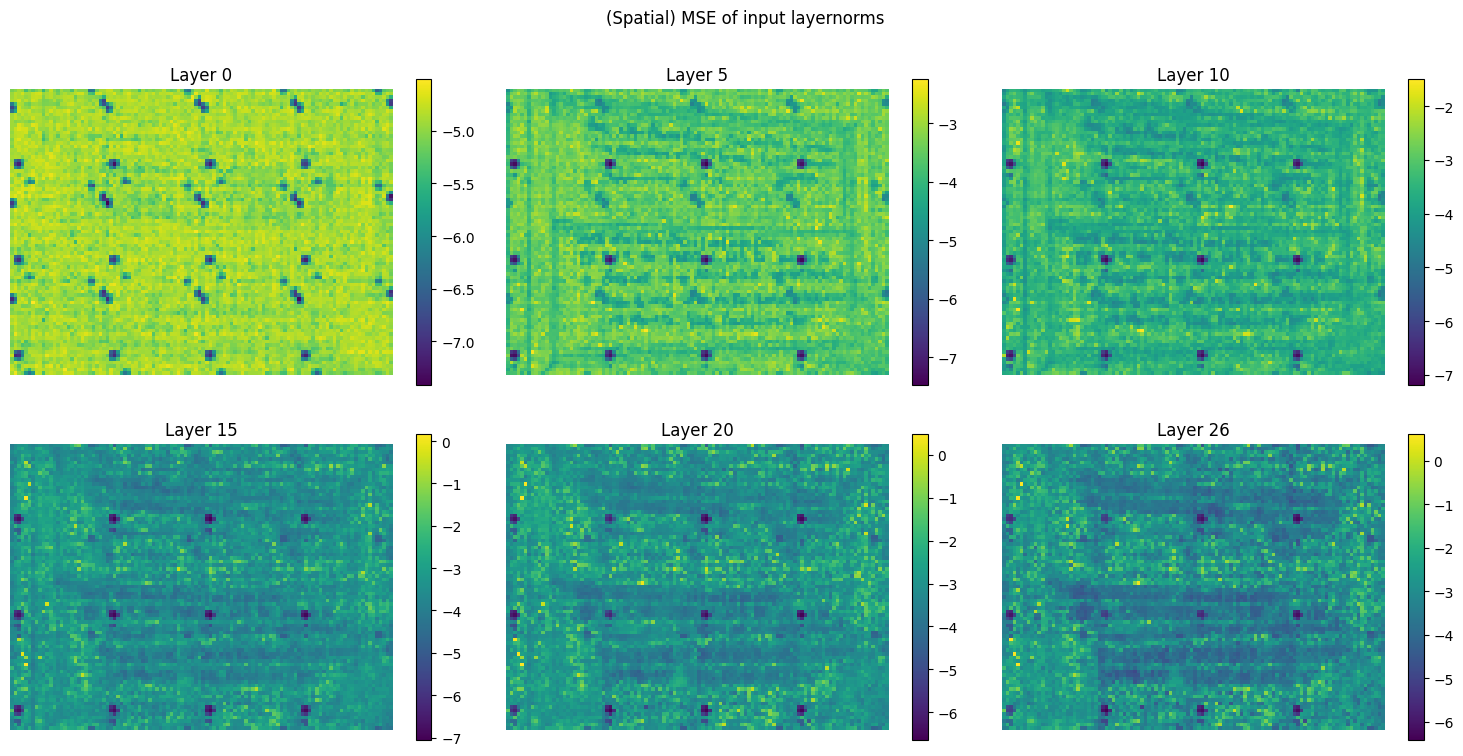

In [16]:
layers_to_show = [0, 5, 10, 15, 20, 26]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_d in enumerate(layers_to_show):
    key = f"input_layernorm_d{layer_d}_i0"
    if key in err_result_spatial:
        im = axes[i].imshow(torch.log10(err_result_spatial[key]+1e-40))
        axes[i].set_title(f'Layer {layer_d}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], shrink=0.8)


plt.suptitle("(Spatial) MSE of input layernorms")
plt.tight_layout()
plt.show()

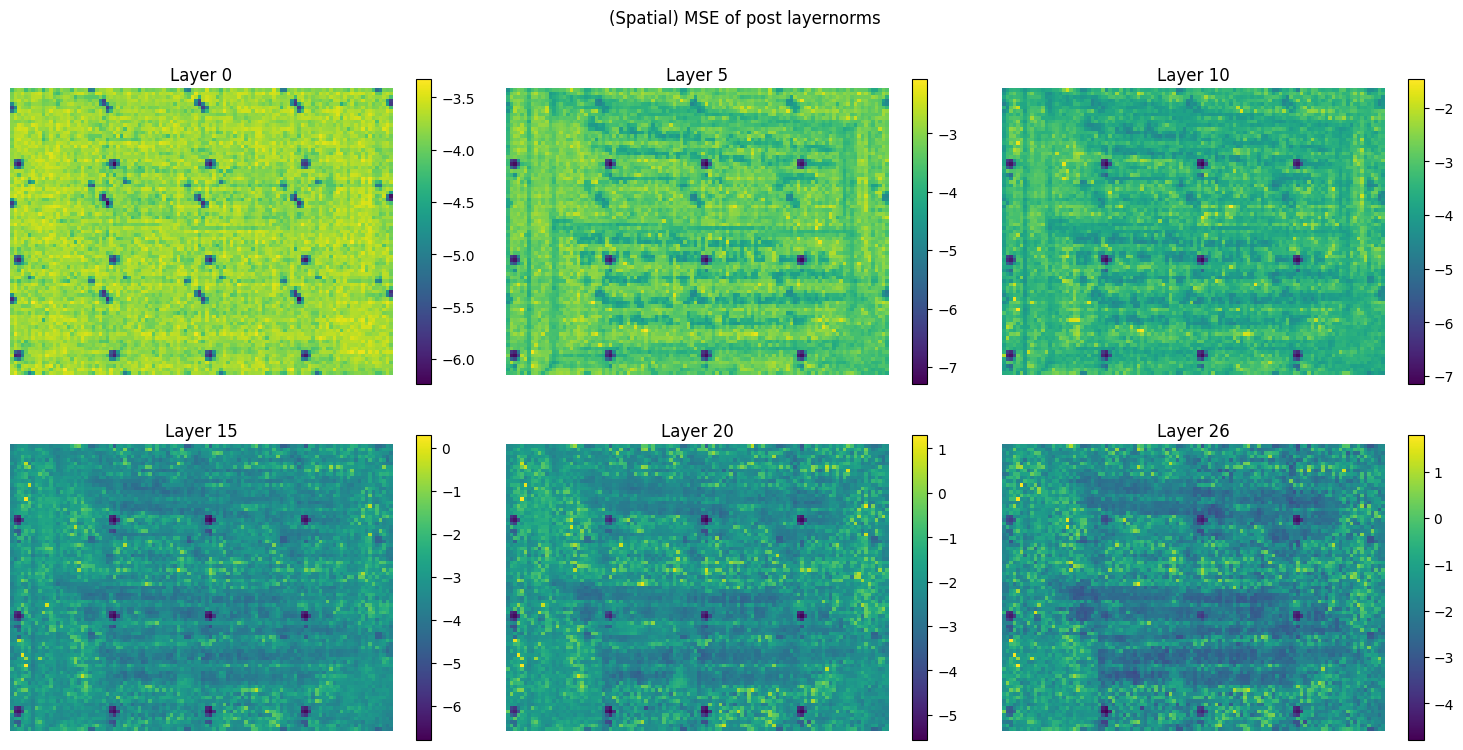

In [17]:
layers_to_show = [0, 5, 10, 15, 20, 26]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_d in enumerate(layers_to_show):
    key = f"post_layernorm_d{layer_d}_i0"
    if key in err_result_spatial:
        im = axes[i].imshow(torch.log10(err_result_spatial[key]))
        axes[i].set_title(f'Layer {layer_d}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], shrink=0.8)

plt.suptitle("(Spatial) MSE of post layernorms")
plt.tight_layout()
plt.show()

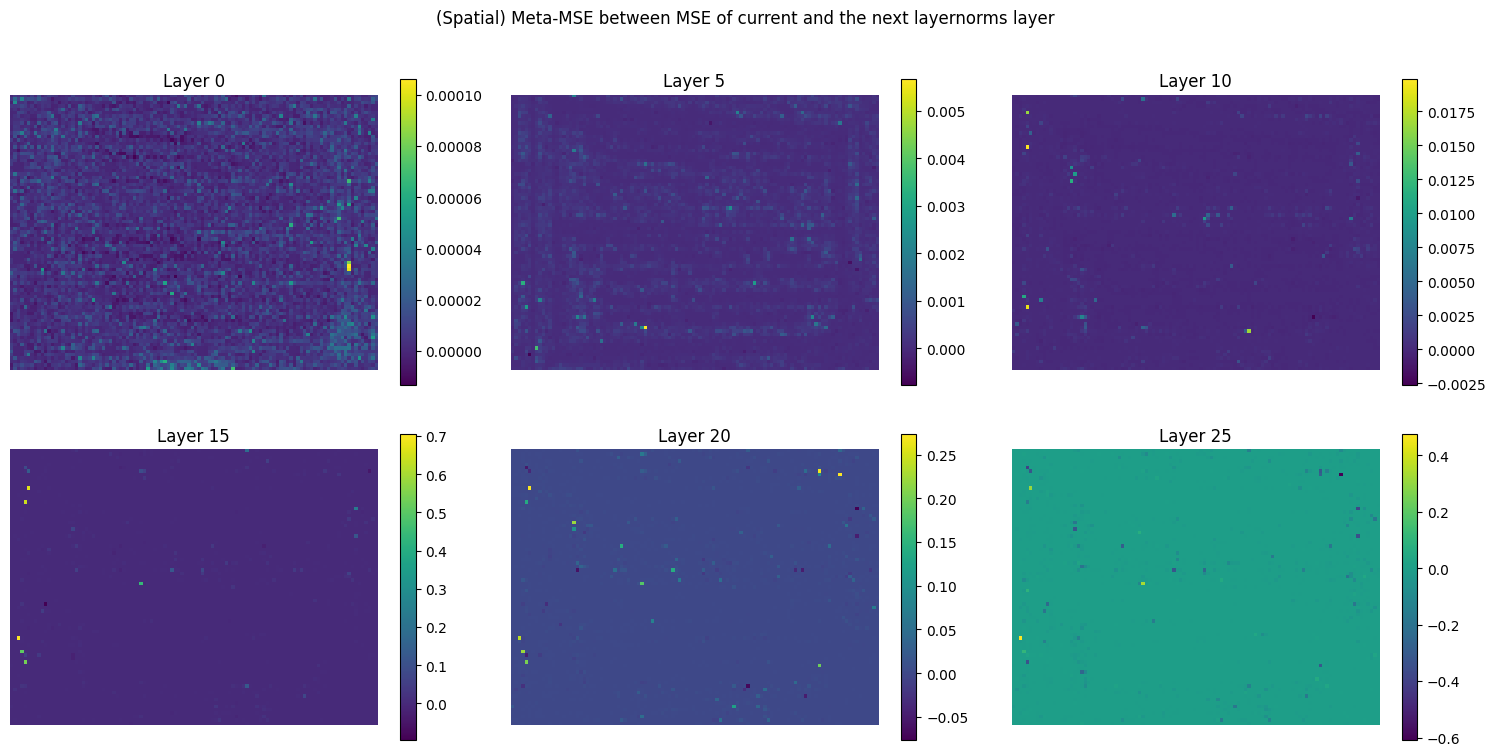

In [ ]:
layers_to_show = [0, 5, 10, 15, 20, 25]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_d in enumerate(layers_to_show):
    key = f"input_layernorm_d{layer_d}_i0"
    key2 = f"input_layernorm_d{layer_d+1}_i0"
    if key in err_result_spatial:
        s = err_result_spatial[key2]-err_result_spatial[key]
        # s = err_result_spatial[key2]
        im = axes[i].imshow(s)
        axes[i].set_title(f'Layer {layer_d}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], shrink=0.8)

plt.suptitle("(Spatial) Error between MSE of current and the next layernorms layer")
plt.tight_layout()
plt.show()

# Evaluations